In [1]:
# load these packages
from pyspark.ml import feature
from pyspark.ml import clustering
from pyspark.ml import Pipeline
from pyspark.ml import pipeline
from pyspark.sql import functions as fn
import numpy as np
from pyspark.sql import SparkSession
from pyspark.ml import feature, regression, evaluation, Pipeline
from pyspark.sql import functions as fn, Row
import matplotlib.pyplot as plt
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext
import pandas as pd

The following dataset contains information about Spotify songs.

In [2]:
spotify_df = spark.read.csv('/datasets/spotify_songs.csv',
                            inferSchema=True, header=True).\
                     orderBy(['song_title', 'artist'])

In [3]:
spotify_df.head()

Row(song_title='"Beauty and the Beast - From ""Beauty and the Beast"""', artist='Ariana Grande', acousticness=0.152, danceability=0.494, duration_ms=227928, energy=0.542, instrumentalness=0.0, key=6, liveness=0.10099999999999999, loudness=-6.995, mode=1, speechiness=0.0277, tempo=81.34, time_signature=4.0, valence=0.24600000000000002)



Create a fitted pipeline `pipe_pca` that takes the features `acousticness`, `danceability`, `duration_ms`, `energy`, `instrumentalness`, `key`, `liveness`, `loudness`, `mode`, `speechiness`, `tempo`, `time_signature`, and `valence` (in that order), 2) standardize them, and 3) compute the two first principal components. The pipeline should produce a column `pc` which contains these components.

Create a dataframe `spotify_pc_df` with all columns of `spotify_df`, in the same order, and the column `pc`.

In [4]:

pipe_pca = Pipeline(stages=[
    feature.VectorAssembler(inputCols=['acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'key', 'liveness', 'loudness', 'mode', 'speechiness', 'tempo', 'time_signature', 'valence'],
                           outputCol='features'),
    feature.StandardScaler(withMean=True,
                           inputCol='features', outputCol='zfeatures'
                          ),
    feature.PCA(k=2, inputCol='zfeatures', outputCol='pc')
]).fit(spotify_df)

spotify_pc_df = pipe_pca.transform(spotify_df)
spotify_pc_df.show()
#raise NotImplementedError()

+--------------------+------------------+--------------------+-------------------+-----------+-------------------+--------------------+---+-------------------+-------------------+----+--------------------+------------------+--------------+-------------------+--------------------+--------------------+--------------------+
|          song_title|            artist|        acousticness|       danceability|duration_ms|             energy|    instrumentalness|key|           liveness|           loudness|mode|         speechiness|             tempo|time_signature|            valence|            features|           zfeatures|                  pc|
+--------------------+------------------+--------------------+-------------------+-----------+-------------------+--------------------+---+-------------------+-------------------+----+--------------------+------------------+--------------+-------------------+--------------------+--------------------+--------------------+
|"Beauty and the B...|     Aria

In [5]:
columns_to_drop = ['artist', 'features','zfeatures','song_title']
spotify_pc_df= spotify_pc_df.drop(*columns_to_drop)

In [6]:
# Tests for (10 pts)
np.testing.assert_equal(type(pipe_pca),  pipeline.PipelineModel)
np.testing.assert_equal(set(spotify_pc_df.columns), {'acousticness',
 'danceability',
 'duration_ms',
 'energy',
 'instrumentalness',
 'key',
 'liveness',
 'loudness',
 'mode',
 'speechiness',
 'tempo',
 'time_signature',
 'valence', 'pc'})
np.testing.assert_equal(spotify_pc_df.first().pc.shape, (2, ))



Create a scatter plot with the x axis containing the first principal component and the y axis containing the second principal component of `ds_features_df`

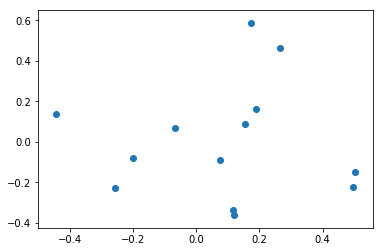

In [7]:


pc1 = pipe_pca.stages[-1].pc.toArray()[:, 0].tolist()
pc2 = pipe_pca.stages[-1].pc.toArray()[:, 1].tolist()
ds_features_df = pd.DataFrame([pc1, pc2]).T.rename(columns={0: 'pc1', 1: 'pc2'})

ds_features_df
plt.scatter(pc1, pc2)




Create two Pandas dataframes `pc1_pd` and `pc2_pd` with the columns `feature` and `abs_loading` that contain the top 3 features in absolute loading for the principal components 1 and 2, respetively.

In [8]:

listk = list(zip(['acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'key', 'liveness', 'loudness', 'mode', 'speechiness', 'tempo', 'time_signature', 'valence']))
pc1_pd = pd.DataFrame([listk, pc1]).T.rename(columns={0: 'feature', 1: 'abs_loading'})#.sort_values('abs_loading', ascending = True).head(3)
pc2_pd = pd.DataFrame([listk, pc2]).T.rename(columns={0: 'feature', 1: 'abs_loading'})#.sort_values('abs_loading', ascending = True).head(3)
pc1_pd=pc1_pd.iloc[pc1_pd['abs_loading'].abs().argsort()].tail(3)
pc2_pd=pc2_pd.iloc[pc2_pd['abs_loading'].abs().argsort()].tail(3)
#pc1_pd=pc1_pd.sort_values('abs_loading', ascending = False)#.head(3)
#pc2_pd=pc2_pd.iloc[pc2_pd['abs_loading'].abs().argsort()].sort_values('abs_loading', ascending = False)#.head(3)
#pc1_pd = pc1_pd.sort_values(by =abs(pc1_pd['pc1']), ascending = True)


In [9]:
pc1_pd

,feature,abs_loading
0,"(acousticness,)",-0.442305
3,"(energy,)",0.496684
7,"(loudness,)",0.50343


In [10]:
pc2_pd

,feature,abs_loading
6,"(liveness,)",-0.362308
12,"(valence,)",0.465056
1,"(danceability,)",0.586402


create a new pipeline for PCA called `pipe_pca2` where you fit 10 principal components instead of the 3 above. Extract the `PCAModel` from the stages of this pipeline, and assign to a variable `explainedVariance` the variance explained by components of such model. Finally, assign to a variable `best_k` the value $k$ such that the ($k+1$)-th component explains less than 0.01 variance. You can use a for-loop to find such best k.

In [12]:

pipe_pca2 = Pipeline(stages=[
    feature.VectorAssembler(inputCols=['acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'key', 'liveness', 'loudness', 'mode', 'speechiness', 'tempo', 'time_signature', 'valence'],
                           outputCol='features'),
    feature.StandardScaler(withMean=True,
                           inputCol='features', outputCol='zfeatures'
                          ),
    feature.PCA(k=10, inputCol='zfeatures', outputCol='pc')
]).fit(spotify_df)

PCAModel=pipe_pca2.stages[-1]
explainedVariance = PCAModel.explainedVariance


In [13]:
for i in range(len(explainedVariance)):
    if i == len(explainedVariance)-1:
        print("No component with variance less than 0.01 hence, best k is")
        best_k = i+1
        break
        
    elif explainedVariance[i] < 0.01:
        best_k = i+1
        #print("none1")
        break
    else:
        #print("none")
        continue
print(best_k)

No component with variance less than 0.01 hence, best k is
10


In [14]:
explainedVariance

DenseVector([0.2191, 0.1176, 0.101, 0.0866, 0.0793, 0.0746, 0.069, 0.0612, 0.0577, 0.0504])

In [16]:
spotify_df.show()

+--------------------+------------------+--------------------+-------------------+-----------+-------------------+--------------------+---+-------------------+-------------------+----+--------------------+------------------+--------------+-------------------+
|          song_title|            artist|        acousticness|       danceability|duration_ms|             energy|    instrumentalness|key|           liveness|           loudness|mode|         speechiness|             tempo|time_signature|            valence|
+--------------------+------------------+--------------------+-------------------+-----------+-------------------+--------------------+---+-------------------+-------------------+----+--------------------+------------------+--------------+-------------------+
|"Beauty and the B...|     Ariana Grande|               0.152|              0.494|     227928|              0.542|                 0.0|  6|0.10099999999999999|             -6.995|   1|              0.0277|             81



Performed k-means on the features (not standardized) of the Spotify dataset with k = 5. Did this by creating a fitted pipeline `pipe_kmeans` that produces a column `cluster` with the cluster membership number of a song. Created a second fitted pipeline `pipe_analysis` that combines both `pipe_pca` and `pipe_kmeans` and fit it to the data. Finally, created a dataframe `spotify_features_df` that contains as columns the principal components `pc` and the cluster membership `cluster`. 

In [17]:

pipe_kmeans=Pipeline(stages=[feature.VectorAssembler(inputCols=['acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'key', 'liveness', 'loudness', 'mode', 'speechiness', 'tempo', 'time_signature', 'valence'],
                           outputCol='feature'),
                             clustering.KMeans(k=5, featuresCol='feature', predictionCol='cluster')]).fit(spotify_df)
pipe_analysis = Pipeline(stages=[pipe_pca,pipe_kmeans]).fit(spotify_df)
spotify_features= pipe_analysis.transform(spotify_df).select("pc","cluster")
spotify_features


DataFrame[pc: vector, cluster: int]

Below, created a plot with the x axis being the first principal component and y-axis being the second principal component, using `spotify_features`. Set the color of each song with the cluster number.

In [19]:
spotify_featurespd = spotify_features.toPandas()
spotify_featurespd.astype({'cluster': 'category'}).dtypes
#spotify_featurespd

pc           object
cluster    category
dtype: object

In [20]:
import seaborn as sns;

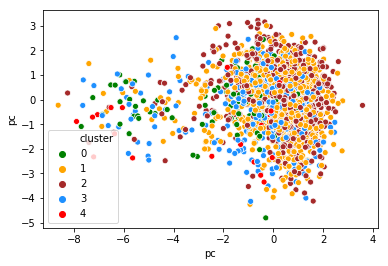

In [21]:
#data = sns.load_dataset("spotify_featurespd")
x1 = spotify_featurespd.pc.apply(lambda d:d[0])
y1 = spotify_featurespd.pc.apply(lambda d:d[1])
ax = sns.scatterplot(x=x1, y=y1,hue='cluster',palette=['green','orange','brown','dodgerblue','red'] ,data=spotify_featurespd)
